In [22]:
import os
os.chdir("..")

Load Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor

In [3]:
import numpy as np

def get_error_stats(sim, obs, pcol="exc_prb", ycol="precip_avg_mm", to_inches=True):
    f = 25.4 if to_inches else 1.0
    cx = (1 / sim[pcol].to_numpy()).astype(float)
    cy = (sim[ycol].to_numpy() / f).astype(float)
    mx = (1 / obs[pcol].to_numpy()).astype(float)
    my = (obs[ycol].to_numpy() / f).astype(float)

    # clean & sort
    okc, okm = np.isfinite(cx*cy), np.isfinite(mx*my)
    cx, cy = cx[okc], cy[okc]; mx, my = mx[okm], my[okm]
    i, j = np.argsort(cx), np.argsort(mx)
    cx, cy, mx, my = cx[i], cy[i], mx[j], my[j]

    # integer grid 1..floor(max mx)
    xmax = float(mx.max())
    grid = np.arange(1, int(np.floor(xmax)) + 1, dtype=float)

    cyg = np.interp(grid, cx, cy)
    myg = np.interp(grid, mx, my)
    rmse = float(np.sqrt(np.mean((cyg - myg) ** 2)))

    # diff at exact max of monte
    diff_at_max = float(np.interp(xmax, cx, cy) - np.interp(xmax, mx, my))
    return {"rmse": rmse, "diff_at_max": diff_at_max}

Preprocess data

In [ ]:
# Only do once. Reload once run.
denton = Preprocessor(config_path = "/workspaces/Importance-Sampling-for-SST/data/0_source/Denton/config.json", 
                      output_folder = "/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton")
denton.run()

In [24]:
#Reload
denton = Preprocessor.load(config_path = "/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton/config.json")

Full Monte Uniform Samples

In [25]:
sampler = ImportanceSampler(
    distribution="uniform",
    params = {},
    num_simulations=1_000_000,
    num_rep=1,
)

denton_fullmonte_samples = sampler.sample(denton.domain_gdf, denton.watershed_gdf)

In [26]:
processor = StormDepthProcessor(
    precip_cube=denton.cumulative_precip,
    storm_centers=denton.storm_centers,
    watershed_gdf=denton.watershed_gdf
)

denton_fullmonte_depths = processor.shift_and_extract_precip(
    df_storms=denton_fullmonte_samples,
    n_jobs=-1,    
    seed=42   
)

In [27]:
#Save
denton_fullmonte_depths.to_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton/denton_fullmonte_depths.pq")

In [5]:
#Read
denton_fullmonte_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton/denton_fullmonte_depths.pq")

Importance Sampling - Truncated Normals

In [6]:
#Sample
params = {
    "mu_x": denton.watershed_stats["x"],  
    "mu_y": denton.watershed_stats["y"],      
    "sd_x": denton.watershed_stats["range_x"]*6,
    "sd_y": denton.watershed_stats["range_y"]*3,                            
}

sampler = ImportanceSampler(
    distribution="truncated_gaussian",
    params=params,
    num_simulations=350_000,
    num_rep=1,
    seed=42,
)

samples = sampler.sample(denton.domain_gdf)

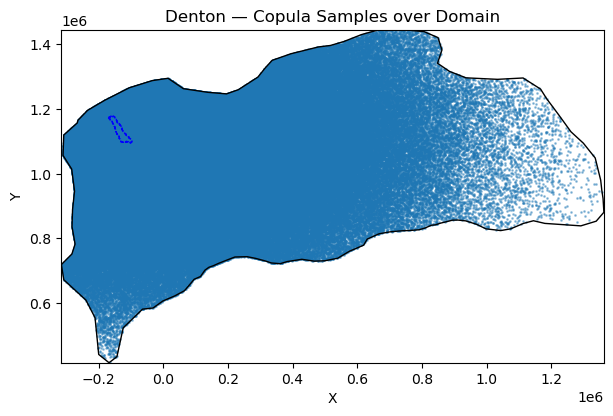

In [7]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
denton.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
denton.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    samples["x"].to_numpy(),
    samples["y"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = denton.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Denton — Copula Samples over Domain")
plt.show()

In [8]:
#Transpose
processor = StormDepthProcessor(
    precip_cube=denton.cumulative_precip,
    storm_centers=denton.storm_centers,
    watershed_gdf=denton.watershed_gdf
)

denton_gaussian_depths = processor.shift_and_extract_precip(
    df_storms=samples,
    n_jobs=-1,    
    seed=42   
)

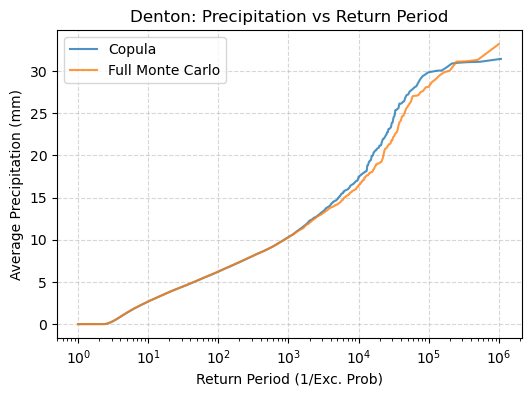

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(1/denton_gaussian_depths["exc_prb"], denton_gaussian_depths["precip_avg_mm"]/25.4, 
         label="Copula", alpha=0.8)
plt.plot(1/denton_fullmonte_depths["exc_prb"], denton_fullmonte_depths["precip_avg_mm"]/25.4, 
         label="Full Monte Carlo", alpha=0.8)

plt.xscale("log")  # log scale for return period
plt.xlabel("Return Period (1/Exc. Prob)")
plt.ylabel("Average Precipitation (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Denton: Precipitation vs Return Period")
plt.show()

In [12]:
get_error_stats(denton_gaussian_depths,denton_fullmonte_depths,pcol="exc_prb", ycol="precip_avg_mm", to_inches=True)

{'rmse': 0.976196864171963, 'diff_at_max': -1.797288639698511}

Importance Sampling - Gaussian Copula

In [ ]:
#Sample
params = {
    "mu_x": denton.watershed_stats["x"],  
    "mu_y": denton.watershed_stats["y"],      
    "sd_x": denton.watershed_stats["range_x"]*6,
    "sd_y": denton.watershed_stats["range_y"]*3, 
    "rho": -0.2,                                
}

sampler = ImportanceSampler(
    distribution="gaussian_copula",
    params=params,
    num_simulations=350_000,
    num_rep=1,
    seed=42,
)

samples = sampler.sample(denton.domain_gdf)

In [ ]:
#Transpose
processor = StormDepthProcessor(
    precip_cube=denton.cumulative_precip,
    storm_centers=denton.storm_centers,
    watershed_gdf=denton.watershed_gdf
)

denton_copula_depths = processor.shift_and_extract_precip(
    df_storms=samples,
    n_jobs=-1,    
    seed=42   
)

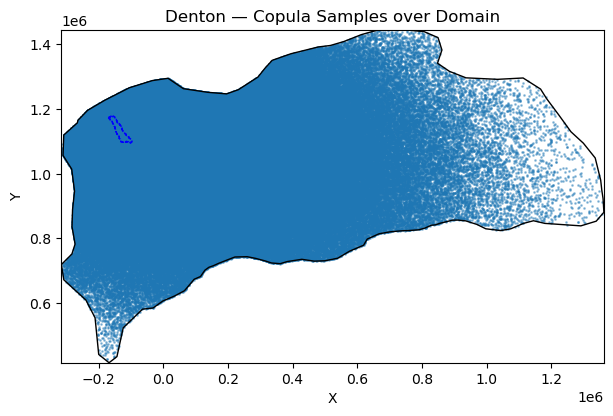

In [74]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
denton.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
denton.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    samples["x"].to_numpy(),
    samples["y"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = denton.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Denton — Copula Samples over Domain")
plt.show()


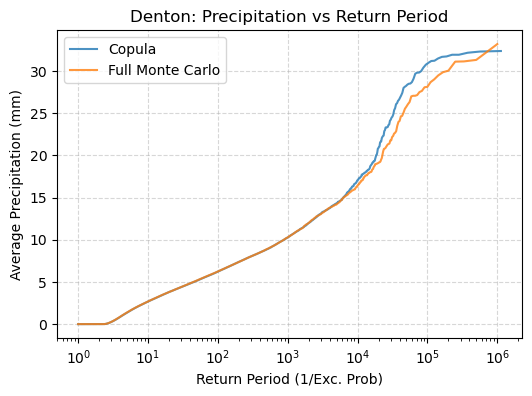

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(1/denton_copula_depths["exc_prb"], denton_copula_depths["precip_avg_mm"]/25.4, 
         label="Copula", alpha=0.8)
plt.plot(1/denton_fullmonte_depths["exc_prb"], denton_fullmonte_depths["precip_avg_mm"]/25.4, 
         label="Full Monte Carlo", alpha=0.8)

plt.xscale("log")  # log scale for return period
plt.xlabel("Return Period (1/Exc. Prob)")
plt.ylabel("Average Precipitation (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Denton: Precipitation vs Return Period")
plt.show()

In [ ]:
get_error_stats(denton_copula_depths,denton_fullmonte_depths,pcol="exc_prb", ycol="precip_avg_mm", to_inches=True)

{'rmse': 1.1646298804102448, 'diff_at_max': -0.8310427560693086}

Mixture of two normals

In [16]:
#Sample
params = {
    "mu_x_narrow": denton.watershed_stats["x"],  
    "mu_y_narrow": denton.watershed_stats["y"],
    "mu_x_wide": denton.domain_stats["x"],  
    "mu_y_wide": denton.domain_stats["y"],
    "sd_x_narrow": denton.watershed_stats["range_x"],
    "sd_y_narrow": denton.watershed_stats["range_y"],
    "sd_x_wide": denton.domain_stats["range_x"],
    "sd_y_wide": denton.domain_stats["range_y"],
    "mix": 0.8,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

sampler = ImportanceSampler(
    distribution="mixture_trunc_gauss",
    params=params,
    num_simulations=200_000,
    num_rep=1,
    seed=42,
)

samples = sampler.sample(denton.domain_gdf)

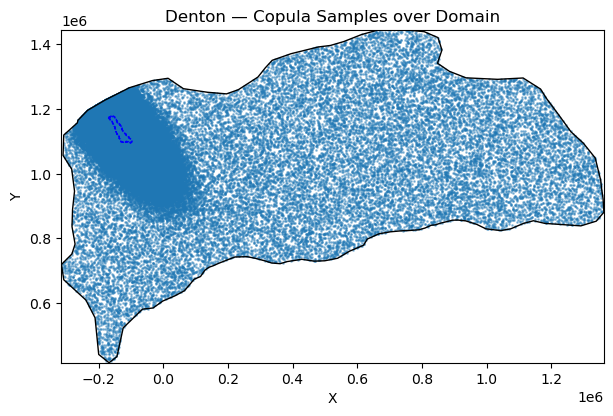

In [17]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
denton.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
denton.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    samples["x"].to_numpy(),
    samples["y"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = denton.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Denton — Copula Samples over Domain")
plt.show()

In [18]:
#Transpose
processor = StormDepthProcessor(
    precip_cube=denton.cumulative_precip,
    storm_centers=denton.storm_centers,
    watershed_gdf=denton.watershed_gdf
)

denton_mixture_depths = processor.shift_and_extract_precip(
    df_storms=samples,
    n_jobs=-1,    
    seed=42   
)

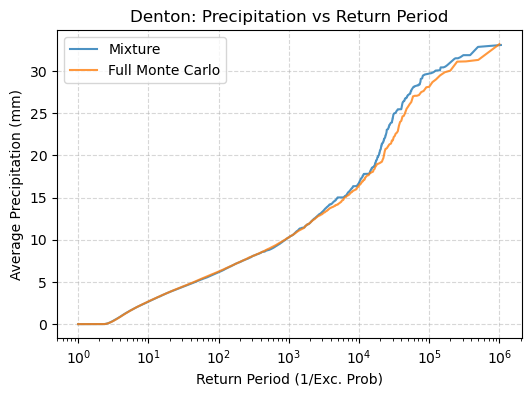

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(1/denton_mixture_depths["exc_prb"], denton_mixture_depths["precip_avg_mm"]/25.4, 
         label="Mixture", alpha=0.8)
plt.plot(1/denton_fullmonte_depths["exc_prb"], denton_fullmonte_depths["precip_avg_mm"]/25.4, 
         label="Full Monte Carlo", alpha=0.8)

plt.xscale("log")  # log scale for return period
plt.xlabel("Return Period (1/Exc. Prob)")
plt.ylabel("Average Precipitation (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Denton: Precipitation vs Return Period")
plt.show()

In [21]:
get_error_stats(denton_mixture_depths,denton_fullmonte_depths,pcol="exc_prb", ycol="precip_avg_mm", to_inches=True)

{'rmse': 0.9630839832822389, 'diff_at_max': -0.12560529539446463}

Adaptive Importance Sampling - Mixtures